In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import common_functions as cf
import keras_tuner as kt

from keras import models
from keras import layers

In [2]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# CNN

In [3]:
def MakeModel(class_names: list) -> tf.keras.Sequential:
    """
    Simple straight forward CNN model. this is just for simplicity and testing
    atm. I will make it more modular later once I know what we are doing

    Args:
        class_names: list of the classification names
        conv_layers: list of how many filters each convolutional layer should use
        layers: list with the sizes of each hidden layer
    
    Returns:
        `tf.keras.Sequential` - a constructed tf model
    """
    tf.keras.backend.clear_session()

    def build_model(hp):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Rescaling(1./255))
        for _ in range(1, hp.Int("num_conv_layers", 1, 2)):
            model.add(tf.keras.layers.Conv2D(hp.Int("conv_filters", 16, 28, 7), 3, activation='relu'))
            model.add(tf.keras.layers.MaxPooling2D())
        model.add(tf.keras.layers.Flatten())
        for _ in range(1, hp.Int("num_layers", 0, 5)):
            model.add(tf.keras.layers.Dense(hp.Int("units", 32, 512, 32), activation='relu'))
        model.add(tf.keras.layers.Dropout(rate=hp.Float("dropout", 0, 0.5, 0.1)))
        model.add(tf.keras.layers.Dense(len(class_names))) # output

        learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])

        model.compile(
            optimizer=
                tf.keras.optimizers.Adam(learning_rate=learning_rate),
            # hp.Choice("optimizer", values=[
            #     tf.keras.optimizers.SGD(learning_rate=learning_rate)
            # ]),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )

        return model
    
    return build_model

## Load Data

Found 12479 files belonging to 13 classes.
Found 4160 files belonging to 13 classes.
Found 4160 files belonging to 13 classes.


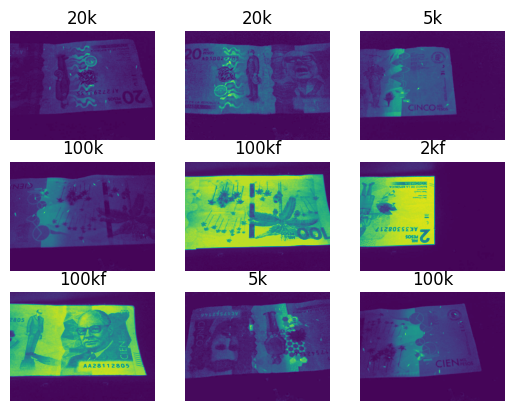

In [4]:
train_ds, test_ds, validation_ds, class_names = cf.LoadData(color="grayscale")
cf.PeakData(train_ds, class_names)

# Run Hyperparameterization

In [5]:
tuner = kt.Hyperband(MakeModel(class_names),
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='hp_logs/cnn',
                     project_name='grayscale')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(
    train_ds, 
    validation_data=validation_ds, 
    epochs=50, 
    callbacks=[stop_early]
)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 25 Complete [00h 03m 52s]
val_accuracy: 0.996874988079071

Best val_accuracy So Far: 0.996874988079071
Total elapsed time: 00h 25m 27s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 352 and the optimal learning rate for the optimizer
is 0.001.



# Find Best Epoch

In [6]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
# .map(cf.AugmentImage(contrast=1))
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10
)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/10
390/390 [==============================] - 23s 56ms/step - loss: 1.2492 - accuracy: 0.6936 - val_loss: 0.2218 - val_accuracy: 0.9498
Epoch 2/10
390/390 [==============================] - 22s 56ms/step - loss: 0.0919 - accuracy: 0.9843 - val_loss: 0.0658 - val_accuracy: 0.9882
Epoch 3/10
390/390 [==============================] - 22s 56ms/step - loss: 0.0214 - accuracy: 0.9987 - val_loss: 0.0268 - val_accuracy: 0.9954
Epoch 4/10
390/390 [==============================] - 22s 57ms/step - loss: 0.0157 - accuracy: 0.9978 - val_loss: 0.0194 - val_accuracy: 0.9957
Epoch 5/10
390/390 [==============================] - 22s 57ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0160 - val_accuracy: 0.9964
Epoch 6/10
390/390 [==============================] - 22s 57ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0157 - val_accuracy: 0.9966
Epoch 7/10
390/390 [==============================] - 22s 57ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0133 - val_accuracy:

# Fit the Best Model

In [7]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=best_epoch,
    validation_split=0.2
)

Epoch 1/9
390/390 [==============================] - 23s 56ms/step - loss: 3.0987 - accuracy: 0.6068 - val_loss: 0.4001 - val_accuracy: 0.9060
Epoch 2/9
390/390 [==============================] - 22s 57ms/step - loss: 0.2575 - accuracy: 0.9365 - val_loss: 0.1456 - val_accuracy: 0.9752
Epoch 3/9
390/390 [==============================] - 22s 56ms/step - loss: 0.0810 - accuracy: 0.9900 - val_loss: 0.0787 - val_accuracy: 0.9882
Epoch 4/9
390/390 [==============================] - 22s 57ms/step - loss: 0.0357 - accuracy: 0.9976 - val_loss: 0.1579 - val_accuracy: 0.9493
Epoch 5/9
390/390 [==============================] - 22s 57ms/step - loss: 0.0332 - accuracy: 0.9963 - val_loss: 0.0285 - val_accuracy: 0.9969
Epoch 6/9
390/390 [==============================] - 22s 57ms/step - loss: 0.0070 - accuracy: 0.9998 - val_loss: 0.0202 - val_accuracy: 0.9971
Epoch 7/9
390/390 [==============================] - 22s 57ms/step - loss: 0.0044 - accuracy: 0.9999 - val_loss: 0.0160 - val_accuracy: 0.9974

# Evaluate

In [8]:
eval_result = hypermodel.evaluate(test_ds)
print("[test loss, test accuracy]:", eval_result)

130/130 [==============================] - 3s 25ms/step - loss: 0.0876 - accuracy: 0.9757
[test loss, test accuracy]: [0.08764303475618362, 0.9757211804389954]


# Results

grayscale, no augmentation, hyperparameterized = 0.998 searched, 0.995 trained, 0.9957 test